<a href="https://colab.research.google.com/github/Spencer-Harrison/Textarkov/blob/master/CNN_fun.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.8 MB/s eta 0:00:00
Mounted at /content/gdrive


In [2]:
#hide
from fastbook import *
from fastai.vision.widgets import *


https://colab.research.google.com/corgiredirector?site=https%3A%2F%2Fazure.microsoft.com%2Fen-us%2Fservices%2Fcognitive-services%2Fbing-web-search-api%2F

In [3]:
key = os.environ.get('AZURE_SEARCH_KEY', 'XXX')

In [4]:
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128, max_images=150)>

In [7]:
results = search_images_bing(key, 'maine coon')
ims = results.attrgot('contentUrl')
ims.append(ims)
len(ims)

148

In [9]:
dest = 'images/cats2.jpg'
download_url(ims[0], dest)

Path('images/cats2.jpg')

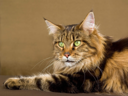

In [10]:
im = Image.open(dest)
im.to_thumb(128,128)

In [11]:
cat_types = 'maine coon','siberian cat'
path = Path('cats')

In [12]:
if not path.exists():
    path.mkdir()
    for o in cat_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o}')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [14]:
fns = get_image_files(path)
fns[-1]

Path('cats/maine coon/8e72c45f-2e99-4df6-a09a-35ceb9363c25.png')

In [15]:
failed = verify_images(fns)
failed

(#3) [Path('cats/siberian/9ec5c099-89cc-4a2a-8ddd-0bcb2f1c99a2.jpg'),Path('cats/maine coon/30e1ec49-2bde-4705-a9b3-0ac0d8848b19.jpg'),Path('cats/maine coon/2662bc44-9780-440a-94c1-bcc22a40c951.jpg')]

In [16]:
failed.map(Path.unlink);

In [17]:
cats = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [18]:
dls = cats.dataloaders(path)

/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


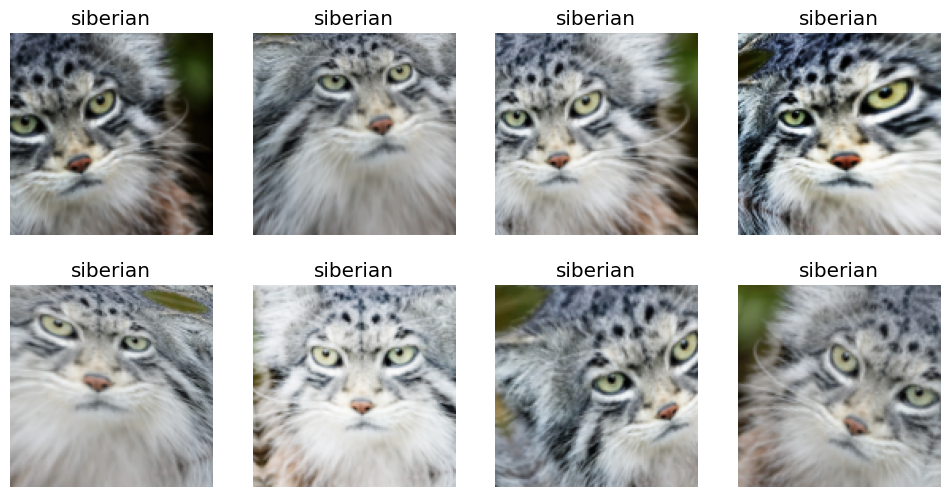

In [21]:
cats = cats.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = cats.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [25]:
cats = cats.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = cats.dataloaders(path)

In [24]:
learn = vision_learner(dls, resnet50, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 79.3MB/s]


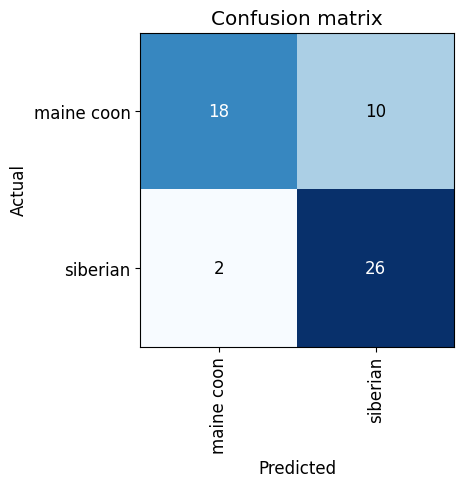

In [26]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

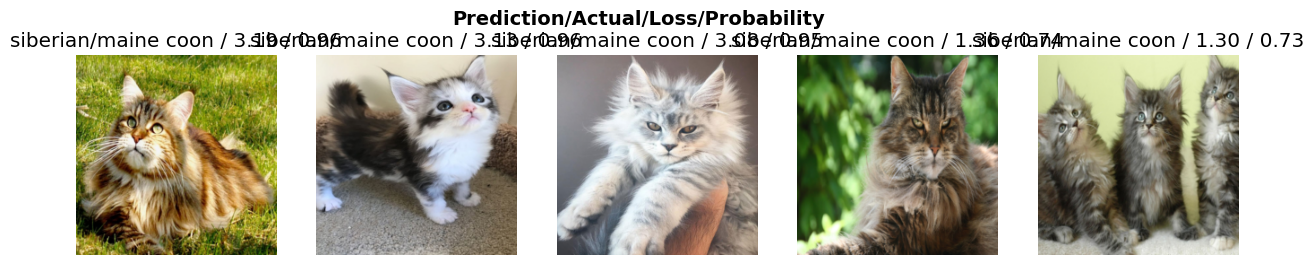

In [27]:
interp.plot_top_losses(5, nrows=1)

In [28]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

In [29]:
learn.export()

In [30]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [31]:
learn_inf = load_learner(path/'export.pkl')

In [38]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [39]:
img = PILImage.create(btn_upload.data[-1])

In [40]:
pred,pred_idx,probs = learn_inf.predict(img)

In [43]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [41]:
#hide_output
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: maine coon; Probability: 0.8226')

In [44]:
#hide_output
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [45]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [46]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [48]:
#hide_output
VBox([widgets.Label('Select your cat!'),
      btn_upload, btn_run, out_pl, lbl_pred])